<a href="https://colab.research.google.com/github/gcfc/academic_projects/blob/main/6_832_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.832 Final Project 

### *George Chen, Silvia Knappe*

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [ ]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# others
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, SVG
import sys

# drake
from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator, RigidTransform, RotationMatrix,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource, CoulombFriction, FixedOffsetFrame,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial, Parser, PlanarJoint,
                         MathematicalProgram, JacobianWrtVariable, AddMultibodyPlantSceneGraph, JointIndex, 
                         ConnectPlanarSceneGraphVisualizer, eq)
from pydrake.all import (
    Sphere, Cylinder, Box, Capsule, Ellipsoid, SpatialInertia)

from pydrake.all import *
import pydrake.symbolic
from underactuated import FindResource
from pydrake.multibody.jupyter_widgets import *

from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(
    server_args=['--ngrok_http_tunnel'] if 'google.colab' in sys.modules else [])

## Parse the `urdf` and Get the `MultibodyPlant`

We start by defining a couple of physical parameters that we will need below.

Remember to download the urdf here https://raw.githubusercontent.com/DAIRLab/dairlib/master/examples/PlanarWalker/PlanarWalker.urdf 

In [ ]:
### GROUND CONSTANTS ###
block_width = 0.6
blocc_thicc = 0.1
step_height = 0.06 # step height between blocks
num_blocks = 4 # 10 (6 if you want pretty graphs)
max_theta = np.pi/8 # max theta for random rotation of block

starting_x = 0
starting_z = -1


In [ ]:
ground_box_urdf = f"""
<?xml version="1.0" ?>

<robot name="ground_box">

  <!-- ground -->
  <!-- just for visualization, it is welded to world -->

  <link name="ground">

    <visual>
      <origin xyz="0 0 -0.05" rpy="0 0 0"/>
      <geometry>
        <box size="{block_width} 5 {blocc_thicc}" />
      </geometry>
      <material name="green">
        <color rgba="0 1 0 1" />
      </material>
    </visual>

    <collision>
      <origin xyz="0 0 -0.05" rpy="0 0 0"/>
      <geometry>
        <box size=".5 5 .1" />
      </geometry>
    </collision>

  </link>
</robot>
  <joint name="ground_is_world" type="fixed">

    <parent link="world" />
    <child link="ground" />
    <!-- slope of the ramp here -->
    <origin xyz="0 0 0" rpy="0 .04 0"/>

  </joint>
</robot>
"""

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://aaf015d6da1f.ngrok.io/static/
Connected to meshcat-server.
size: 3
frames: 21


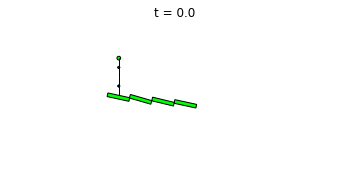

FloatSlider(value=0.0, description='planar_x', layout=Layout(width="'200'"), max=10.0, min=-10.0, step=0.01, s…

FloatSlider(value=0.0, description='planar_z', layout=Layout(width="'200'"), max=10.0, min=-10.0, step=0.01, s…

FloatSlider(value=0.0, description='planar_roty', layout=Layout(width="'200'"), max=10.0, min=-10.0, step=0.01…

FloatSlider(value=0.0, description='hip_pin', layout=Layout(width="'200'"), max=10.0, min=-10.0, step=0.01, st…

FloatSlider(value=0.0, description='left_knee_pin', layout=Layout(width="'200'"), max=10.0, min=-10.0, step=0.…

FloatSlider(value=0.0, description='right_knee_pin', layout=Layout(width="'200'"), max=10.0, min=-10.0, step=0…

In [ ]:
# parse urdf with scene graph
# build block diagram and drive system state with
# the trajectory from the optimization problem
builder = DiagramBuilder()
planar_walker, pw_scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
pw_filename = "PlanarWalker.urdf" # UPLOAD THIS
parser = Parser(planar_walker)
parser.AddModelFromFile(pw_filename)

#the ground
DETERMINISTIC_GROUND = True
seed = 0 if DETERMINISTIC_GROUND else None
rs = np.random.RandomState(seed=seed)
x = starting_x
z = starting_z
ths = []
blocc_frames_index = []
for i in range(num_blocks):
    instance = parser.AddModelFromString(ground_box_urdf, "urdf", f"box{i}")
    th = rs.uniform(0, max_theta)
    ths.append(th)
    randomRot = RotationMatrix.MakeYRotation(th)
    #rot = RotationMatrix.MakeYRotation(0);
    RT = RigidTransform(randomRot, [x, 0, z])
    frame = planar_walker.GetFrameByName("ground", instance)
    blocc_frames_index.append(frame.index())
    planar_walker.WeldFrames(planar_walker.world_frame(), frame, RT)

    x += block_width
    z -= step_height

planar_walker.Finalize()

viz = ConnectMeshcatVisualizer(builder, pw_scene_graph, zmq_url = zmq_url,)
viz.load()


# number of configuration variables
nq = planar_walker.num_positions()

# number of components of the contact forces
nf = 2

# add visualizer
xlim = [-3., 6.]
ylim = [-3., 1.]
# show = True flag shows the model
vis = ConnectPlanarSceneGraphVisualizer(builder, pw_scene_graph, xlim=xlim, ylim=ylim, show=True)


# Make the diagram and run it.
diagram = builder.Build()
context = diagram.CreateDefaultContext()
# print("q: ", planar_walker.GetPositions(context))

# get geometry ids for feet and ground
inspector = pw_scene_graph.model_inspector()
ground_ids = []
for id in inspector.GetAllGeometryIds():
  name = inspector.GetName(id)
  if name.startswith("box") and name.find("Collision") > 0:
    ground_ids.append(id)
  elif name.startswith("KneedCompassGait::right_lower_leg_Collision"):
    rightfoot = id
  elif name.startswith("KneedCompassGait::left_lower_leg_Collision"):
    leftfoot = id

othercontext = diagram.CreateDefaultContext()
query = pw_scene_graph.get_query_output_port().Eval(pw_scene_graph.GetMyContextFromRoot(othercontext))
#print(query.HasCollisions()) #testing
# print(planar_walker.GetBodyIndices())

#constraint for plant foot touching ground- make sure distance is 0
# for id in ground_ids:
#   print(query.ComputeSignedDistancePairClosestPoints(id, leftfoot).distance)
#print(query.ComputeSignedDistancePairClosestPoints(leftfoot, rightfoot).distance)
# CONNECT ACTUATION PORTS TO DIAGRAM HERE
print('size:', planar_walker.get_actuation_input_port().size())


# plant_context = planar_walker.GetMyContextFromRoot(context)
# set_home(planar_walker, plant_context)
print('frames:', planar_walker.num_frames())

diagram.Publish(othercontext)

sliders = MakeJointSlidersThatPublishOnCallback(planar_walker, viz, context)

planar_walker_float = planar_walker
# # overwrite MultibodyPlant with its autodiff copy
planar_walker = planar_walker_float.ToAutoDiffXd()

blocc_frames = []
for ind in blocc_frames_index:
  blocc_frames.append(planar_walker.get_frame(ind))

stance_leg = 'left_lower_leg'
swing_leg = 'right_lower_leg'

In [ ]:
print('cool ths',[0.3816179540899949, 0.22562037706185428, 0.02557360859811195, 0.24384799988261832, 0.15005137530771526])

cool ths [0.3816179540899949, 0.22562037706185428, 0.02557360859811195, 0.24384799988261832, 0.15005137530771526]


## Helper Functions for the `MathematicalProgram`

When writing a `MathematicalProgram` in Drake, optimization variables are `symbolic.Variable` objects.
These cannot be passed directly to the `MultibodyPlant` functions (such as `CalcMassMatrix`), which only accept floats or `AutoDiffXd` types.
Hence, if you need to add a constraint which involves the evaluation of a `MultibodyPlant` function, you need to proceed as follows.

Write a python function (say `my_fun`) that, given the numeric value (`float` or `AutoDiffXd`) of certain variables in the problem, returns the numeric value of the quantity that you want to constrain.
Let `vars` be the arguments of this function and `values` its output (both can be arrays).
Using the method `MathematicalProgram.AddConstraint` you can write `prog.AddConstraint(my_fun, lb=values_lb, ub=values_ub, vars=vars)` to enforce the constraints `values_lb <= values <= values_ub`, where `value_lb` and `value_ub` are vectors of floats of appropriate dimensions.
Then, at solution time, the solver will evaluate `my_fun` passing autodiff variables, retrieving in this way the numeric values of the constraint violations and their derivatives.

In the following cell we wrote the functions that we will need to enforce the necessary constraints in the trajectory optimization problem.

In [ ]:
# Function that given the current configuration, velocity,
# acceleration, and contact force at the stance foot, evaluates
# the manipulator equations. The output of this function is a
# vector with dimensions equal to the number of configuration
# variables. If the output of this function is equal to zero
# then the given arguments verify the manipulator equations.
def manipulator_equations(vars):

    #print("manipulator_equations called")

    # split input vector in subvariables
    # configuration, velocity, acceleration, stance-foot force

    # assert vars.size == 3 * nq + nf + 3
    # split_at = [nq, 2 * nq, 3 * nq, 3 * nq + nf, 3 * nq + nf + 1, 3*nq + nf + 2]
    # q, qd, qdd, f, u_hip, u_left, u_right = np.split(vars, split_at)
    
    assert vars.size == 3 * nq + nf + 3
    split_at = [nq, 2 * nq, 3 * nq, 3 * nq + nf]
    q, qd, qdd, f, u = np.split(vars, split_at)

    # set compass gait state
    context = planar_walker.CreateDefaultContext()
    planar_walker.SetPositions(context, q)
    planar_walker.SetVelocities(context, qd)
    
    # matrices for the manipulator equations
    M = planar_walker.CalcMassMatrixViaInverseDynamics(context)
    Cv = planar_walker.CalcBiasTerm(context)
    tauG = planar_walker.CalcGravityGeneralizedForces(context)

    B = planar_walker.MakeActuationMatrix()
    B = np.reshape(np.array([i.value() for i in B.flatten()]), B.shape)
    # Jacobian of the stance foot
    J = get_foot_jacobian(planar_walker, context, stance_leg) # TODO: pass in an index to alternate legs in every solve of prog (every step)

    # return violation / residual of the manipulator equations
    # return M.dot(qdd) + Cv - tauG - J.T.dot(f) - (B_hip.T.dot(np.array([u_hip[0],0,0]).T) + B_left.T.dot(np.array([0, u_left[0], 0]).T) + B_right.T.dot(np.array([0,0,u_right[0]]).T))
    return M.dot(qdd) + Cv - tauG - J.T.dot(f) - B @ u.T

def stance_foot_position(q):
    # get reference frames for the swing leg and the ground
    leg_frame = planar_walker.GetBodyByName(stance_leg).body_frame() # TODO: pass in an index to alternate legs in every solve of prog (every step)
    
    ground_frame = blocc_frames[curr_blocc]
    
    # position of the swing foot in ground coordinates
    context = planar_walker.CreateDefaultContext()
    planar_walker.SetPositions(context, q)
    pos = planar_walker.CalcPointsPositions(
        context,
        leg_frame,
        foot_in_leg[stance_leg], # TODO: pass in an index to alternate legs in every solve of prog (every step)
        ground_frame
    )

    return np.array([pos[0][0], pos[-1][0]], dtype='object')

# Function that given the current configuration, returns
# the distance of the swing foot from the ground (scalar).
# We have penetration if the function output is negative.
# returns x and z distance of swing foot from current block and next block
def swing_foot_position(q):
    """
    
    d = np.min([query.ComputeSignedDistancePairClosestPoints(id, rightfoot).distance for id in ground_ids])
    return np.array([d])

    """
    # get reference frames for the swing leg and the ground
    leg_frame = planar_walker.GetBodyByName(swing_leg).body_frame() # TODO: pass in an index to alternate legs in every solve of prog (every step)
    
    ground_frame = blocc_frames[curr_blocc]
    
    # position of the swing foot in ground coordinates
    context = planar_walker.CreateDefaultContext()
    planar_walker.SetPositions(context, q)
    pos = planar_walker.CalcPointsPositions(
        context,
        leg_frame,
        foot_in_leg[swing_leg], # TODO: pass in an index to alternate legs in every solve of prog (every step)
        ground_frame
    )
    prev_ground_frame = blocc_frames[curr_blocc-1]
    
    # position of the swing foot in ground coordinates
    prev_pos = planar_walker.CalcPointsPositions(
        context,
        leg_frame,
        foot_in_leg[swing_leg], # TODO: pass in an index to alternate legs in every solve of prog (every step)
        prev_ground_frame
    )
    if curr_blocc + 1 >= len(blocc_frames):
        return np.array([prev_pos[0][0], prev_pos[-1][0], pos[0][0], pos[-1][0], pos[0][0], pos[-1][0]], dtype='object')
      
    next_ground_frame = blocc_frames[curr_blocc+1]
    
    # position of the swing foot in ground coordinates
    next_pos = planar_walker.CalcPointsPositions(
        context,
        leg_frame,
        foot_in_leg[swing_leg], # TODO: pass in an index to alternate legs in every solve of prog (every step)
        next_ground_frame
    )
    
    
    # return only the coordinate z
    # (distance normal to the ground)
    #print(swing_foot_position[-1])

    return np.array([prev_pos[0][0], prev_pos[-1][0], pos[0][0], pos[-1][0], next_pos[0][0], next_pos[-1][0]], dtype='object')

# Function that implements the impulsive collision derived in
# the textbook appendix. Arguments are: compass gait configuration,
# velocities before and after heel strike, and the swing-foot
# impulse (in latex, $\int_{t_c^-}^{t_c^+} \lambda dt$).
# Returns a vector of quantities that must vanish in order
# for the impulsive dynamics to be verified: it enforces the velocity
# jump due to the impulse, and the inelastic behavior of the
# collision (zero coefficient of restitution $e$).
# See http://underactuated.mit.edu/multibody.html#impulsive_collision
def reset_velocity_heelstrike(vars):
    
    #print("reset_velocity_heelstrike called")
    # split input vector in subvariables
    # qd_pre: generalized velocity before the heel strike
    # qd_post: generalized velocity after the heel strike
    # imp: swing-foot collision impulse (2d vector)
    assert vars.size == 3 * nq + nf
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd_pre, qd_post, imp = np.split(vars, split_at)

    # set compass gait configuration
    context = planar_walker.CreateDefaultContext()
    planar_walker.SetPositions(context, q)
    
    # get necessary matrices
    M = planar_walker.CalcMassMatrixViaInverseDynamics(context)
    J = get_foot_jacobian(planar_walker, context, swing_leg) # TODO: pass in an index to alternate legs in every solve of prog (every step)
    

    # return a vector that must vanish for the impulsive dynamics to hold
    return np.concatenate((
        M.dot(qd_post - qd_pre) - J.T.dot(imp), # velocity jump due to the impulse
        J.dot(qd_post)                          # zero velocity restitution
    ))

# Function that given a leg, returns the Jacobian matrix for the related foot.
def get_foot_jacobian(planar_walker, context, leg): # TODO: pass in an index to alternate legs in every solve of prog (every step)
    
    #print("get_foot_jacobian called")

    # get reference frames for the given leg and the ground
    leg_frame = planar_walker.GetBodyByName(leg).body_frame()
    
    # ground_frame = planar_walker.GetBodyByName('ground').body_frame() #TODO(silvia)
    ground_frame = blocc_frames[curr_blocc]
    # compute Jacobian matrix
    J = planar_walker.CalcJacobianTranslationalVelocity(
        context,
        JacobianWrtVariable(0),
        leg_frame,
        foot_in_leg[leg], # TODO: pass in an index to alternate legs in every solve of prog (every step)
        ground_frame,
        ground_frame
    )
    # discard y components since we are in 2D
    return J[[0, 2]]

## The Trajectory Optimization Problem

We start by setting some parameters of our optimization problem.

In [ ]:
# time steps in the trajectory optimization
T = 50

# minimum and maximum time interval is seconds
h_min = .005
h_max = .025

# friction coefficient between feet and ground
friction = .2

# position of the feet in the respective leg frame
# (must match the urdf)
foot_in_leg = {
    'left_lower_leg': np.array([0, 0, -0.5]),        # stance foot in stance-leg frame
    'right_lower_leg': np.array([0, 0, -0.5])       # swing foot in swing-leg frame
}

eps = 0.01


We start from the decision variables of the trajectory optimization problem.
Notice that we also add the accelerations `qdd` among the optimization variables here.
This is slightly unusual, and not necessary, but in these circumstances it simplifies a bit the code.

For this version of the notebook, we combine the entire `MathematicalProgram` into one cell, and run it `num_blocks` times. The trajectory from each iteration is appended into a big matrix `x_total_opt` for simulation. 

Now it is your turn to complete the optimization problem.
You need to add five groups of constraints:
1. **Stance foot on the ground for all times.**
This `LinearConstraint` must ensure that $x(t) = y(t) = 0$ for all $t$.
2. **Swing foot on the ground at time zero.**
This constraint must ensure that the initial configuration $\mathbf{q}(0)$ is such that the swing foot is on the ground.
For a more complex robot, this would be a tough nonlinear constraint.
For the compass gait, knowing that the stance foot is on the ground, you should be able to express this as a `LinearConstraint` on the entries of $\mathbf{q}(0)$.
3. **No penetration of the swing foot in the ground for all times.**
This nonlinear constraint can be added using the function `swing_foot_height` we defined above.
Follow the examples from the previous cell to see how to add a nonlinear constraint defined via a python function using `AddConstraint`.
Note that, in this case, you want the upper bound on the function output to be `ub=[np.inf]` for all times.
4. **Stance-foot contact force in friction cone for all times.**
To prevent the robot from slipping, the contact force `f[t]` must lie in the friction cone for all `t`.
This means that the normal component `f[t, 1]` must be nonnegative, and the tangential component `f[t, 0]` must be, in absolute value, lower or equal than the normal component `f[t, 1]` times the friction coefficient (`friction` here).
Note that these conditions can be enforced as three `LinearConstraint`s per time step `t`.
5. **Swing-foot impulse in friction cone.**
To ensure that the swing foot is completely stopped by the heel strike, ensure that the impulse `imp` belongs to the friction cone.
This can be done using `AddLinearConstraint` three times, as for the previous bullet point.

**Troubleshooting:**
Unfortunately, nonlinear solvers are very sensitive.
It can happen that, just changing the order in which you add constraints to the problem, you get a different solution.
We suggest you to add these constraints in the given order: for us it worked fine.

Here we set the initial guess for our optimization problem.

For the time steps `h` we just initialize them to their maximal value `h_max` (somewhat an arbitrary decision, but it works).

For the robot configuration `q`, we interpolate between the initial value `q0_guess` and the final value `- q0_guess`.
In our implementation, the value given below for `q0_guess` made the optimization converge.
But, if you find the need, feel free to tweak this parameter.
The initial guess for the velocity and the acceleration is obtained by differentiating the one for the position.

The normal force `f` at the stance foot is equal to the total `weight` of the robot.

All the other optimization variables are initialized at zero.
(Note that, if the initial guess for a variable is not specified, the default value is zero.)

We can finally solve the problem! Be sure that the solver actually converged: you can check this by looking at the variable `result.is_success()` (printed below).

In [ ]:
x_total_opt = None
h_total_opt = None
curr_blocc = 1
init_cond = None
stance_x = 0
stance_z = 0
swing_x = 0
swing_z = 0
while curr_blocc < num_blocks - 1:
  # initialize program
  prog = MathematicalProgram()

  # vector of the time intervals
  # (distances between the T + 1 break points)
  h = prog.NewContinuousVariables(T, name='h')

  # system configuration, generalized velocities, and accelerations
  q = prog.NewContinuousVariables(rows=T+1, cols=nq, name='q')
  qd = prog.NewContinuousVariables(rows=T+1, cols=nq, name='qd')
  qdd = prog.NewContinuousVariables(rows=T, cols=nq, name='qdd')

  # input 
  u = prog.NewContinuousVariables(rows=T, cols=3, name='u')

  # stance-foot force
  f = prog.NewContinuousVariables(rows=T, cols=nf, name='f')

  # heel strike impulse for the swing leg
  imp = prog.NewContinuousVariables(nf, name='imp')

  # generalized velocity after the heel strike
  # (if "mirrored", this velocity must coincide with the
  # initial velocity qd[0] to ensure periodicity)
  qd_post = prog.NewContinuousVariables(nq, name='qd_post')



  # lower and upper bound on the time steps for all t
  prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

  # link the configurations, velocities, and accelerations
  # uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
  for t in range(T):
      prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
      prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

  # manipulator equations for all t (implicit Euler)
  for t in range(T):
      #vars = np.concatenate((q[t+1], qd[t+1], qdd[t], f[t], u_hip[t], u_left[t], u_right[t]))
      vars = np.concatenate((q[t+1], qd[t+1], qdd[t], f[t], u[t]))
      prog.AddConstraint(manipulator_equations, lb=[0]*nq, ub=[0]*nq, vars=vars)

  # # velocity reset across heel strike
  # # see http://underactuated.mit.edu/multibody.html#impulsive_collision
  vars = np.concatenate((q[-1], qd[-1], qd_post, imp))
  prog.AddConstraint(reset_velocity_heelstrike, lb=[0]*(nq+nf), ub=[0]*(nq+nf), vars=vars)
      
  # # mirror initial and final configuration
  # # see "The Walking Cycle" section of this notebook
  # prog.AddLinearConstraint(eq(q[0], - q[-1]))

  # # mirror constraint between initial and final velocity
  # # see "The Walking Cycle" section of this notebook
  # prog.AddLinearConstraint(qd[0, 0] == 0)
  # prog.AddLinearConstraint(qd[0, 1] == 0)
  prog.AddLinearConstraint(qd[0, 2] == qd_post[2] + qd_post[3])
  prog.AddLinearConstraint(qd[0, 3] == - qd_post[3])

  ## ???
  # prog.AddLinearConstraint(qd[0,:] == np.zeros((nq,1)))
  # prog.AddLinearConstraint(qd[T,:] == np.zeros((nq,1)))
  for t in range(T):
    #prog.AddCost(np.linalg.norm(u[t,:]))
    prog.AddQuadraticCost((u[t,:].dot(np.array([u[t,:]]).T))[0])



  # # stance foot on the ground for all times
  # # TODO: does not work because position not exactly zero idk why...
  for t in range(T):
      #print(q[t].shape)
      prog.AddConstraint(stance_foot_position, 
                         lb=np.array([stance_x, stance_z]), 
                         ub=np.array([stance_x, stance_z]), 
                         vars=q[t]) # TODO: PUT IN INIT COND HERE, HOW TO GET stance foot position FROM final q[]? 
                                                                                                  # TODO: modify stance_foot_position to alternate legs based on curr_block % 2

  # lock knees at time 0 and time end
  prog.AddConstraint(q[0,4] == 0)
  prog.AddConstraint(q[0,5] == 0)
  prog.AddConstraint(q[T,4] == 0)
  prog.AddConstraint(q[T,5] == 0)

  # # swing foot on the previous block at time zero
  # # TODO: does not work because position not exactly zero idk why...
  prog.AddConstraint(swing_foot_position, 
                    lb=np.array([swing_x, swing_z, -np.inf, -np.inf, -np.inf, -np.inf]),    # TODO: PUT IN INIT COND HERE, HOW TO GET swing foot position FROM final q[]?
                                                                                # TODO: modify swing_foot_position to alternate legs based on curr_block % 2
                    ub=np.array([swing_x, swing_z, np.inf, np.inf, np.inf, np.inf]), 
                    vars=q[0])

  # no penetration of the swing foot in the ground for all times
  # # TODO: does not work because position not exactly zero idk why...
  # for t in range(T):
  #     #swing_foot_position(q[t], curr_blocc)
  #     #prog.AddConstraint((swing_foot_position(q[t])))
  #     prog.AddConstraint(swing_foot_position, 
  #                        lb=np.array([0,-np.inf, , -np.inf, -np.inf]), 
  #                        ub=np.array([np.inf, np.inf, np.inf,np.inf]), 
  #                        vars=q[t])

  # for t in range(int(T/4), int(T/2)):
  #   prog.AddConstraint(swing_foot_position, 
  #                     lb=np.array([block_width/2-eps,-np.inf,-np.inf,blocc_thicc-eps, -np.inf, -np.inf]), 
  #                     ub=np.array([np.inf, np.inf, np.inf, np.inf, np.inf,np.inf]), 
  #                     vars=q[t])
    
  prog.AddConstraint(swing_foot_position, 
                        lb=np.array([-block_width/2,-eps,-np.inf,blocc_thicc-eps, -np.inf, -np.inf]), 
                        ub=np.array([block_width/2, np.inf, np.inf, blocc_thicc+eps, np.inf,np.inf]), 
                        vars=q[T//8])

  for t in range(T//2, T):
    prog.AddConstraint(swing_foot_position, 
                      lb=np.array([block_width/2-eps,-np.inf,-np.inf,-np.inf, -np.inf, -eps]), 
                      ub=np.array([np.inf, np.inf, np.inf, np.inf, np.inf,np.inf]), 
                      vars=q[t])

  # # stance-foot contact force in friction cone for all times
  for t in range(T):
    prog.AddLinearConstraint(f[t,1] >= 0)
    prog.AddLinearConstraint(f[t,0] <= friction*f[t,1])

  # # swing-foot impulse in friction cone
  for t in range(T):
    prog.AddLinearConstraint(imp[1] >= 0)
    prog.AddLinearConstraint(imp[0] <= friction*imp[1])
    prog.AddLinearConstraint(imp[0] >= -friction*imp[1])

  # don't be awkward
  for t in range(T):
    prog.AddLinearConstraint(q[t,2]+q[t,3] <= np.pi/2)
    prog.AddLinearConstraint(q[t,2]+q[t,3] >= -np.pi/2)

  # 4 is left, 5 is right
  if stance_leg == 'left_lower_leg':
    stance_knee = 4
    swing_knee = 5
  else:
    stance_knee = 5
    swing_knee = 4
  # TODO: pass in index to switch between q[4] and q[5] every step
  for t in range(T):
      prog.AddLinearConstraint(q[t,stance_knee] == 0) # stance foot straight for all times
  #   prog.AddLinearConstraint(q[t,4] <= np.pi/2)
      prog.AddLinearConstraint(q[t,swing_knee] >= 0) 
  #   prog.AddLinearConstraint(q[t,5] <= np.pi/2)
  prog.AddLinearConstraint(q[T//8,swing_knee] >= np.pi/8) 
  # # swing foot ends in the next block
  # # TODO: does not work because position not exactly zero idk why...
  prog.AddConstraint(swing_foot_position, 
                    lb=np.array([-np.inf,-np.inf,-np.inf,-np.inf,-block_width/4,-eps]),
                    ub=np.array([np.inf,np.inf,np.inf,np.inf,block_width/4,eps]), 
                    vars=q[T])

  prog.AddConstraint(q[T,0] - q[0,0] >= block_width)
  # prog.AddLinearConstraint(q[0,3] == -q[T,3])
  # prog.AddLinearConstraint(q[0,4] == -q[T,4])




  # vector of the initial guess
  initial_guess = np.zeros(prog.num_vars())

  # initial guess for the time step
  h_guess = h_max
  prog.SetDecisionVariableValueInVector(h, [h_guess] * T, initial_guess)

  # linear interpolation of the configuration
  q0_guess = np.zeros((nq,1))

  q_guess_poly = PiecewisePolynomial.FirstOrderHold(
      [0, T * h_guess],
      np.column_stack((q0_guess, - q0_guess))
  )
  qd_guess_poly = q_guess_poly.derivative()
  qdd_guess_poly = q_guess_poly.derivative()

  # set initial guess for configuration, velocity, and acceleration
  q_guess = np.hstack([q_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
  qd_guess = np.hstack([qd_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
  qdd_guess = np.hstack([qdd_guess_poly.value(t * h_guess) for t in range(T)]).T

  prog.SetDecisionVariableValueInVector(q, q_guess, initial_guess)
  prog.SetDecisionVariableValueInVector(qd, qd_guess, initial_guess)
  prog.SetDecisionVariableValueInVector(qdd, qdd_guess, initial_guess)

  # initial guess for the normal component of the stance-leg force
  bodies = ['hip', 'left_upper_leg', 'left_lower_leg', 'right_upper_leg', 'right_lower_leg']
  mass = sum(planar_walker.GetBodyByName(body).default_mass() for body in bodies)
  g = - planar_walker.gravity_field().gravity_vector()[-1]
  weight = mass * g
  prog.SetDecisionVariableValueInVector(f[:, 1], [weight] * T, initial_guess)

  

  print(f"curr_blocc: {curr_blocc}", end = '\t')
  # solve mathematical program with initial guess
  solver = SnoptSolver()
  result = solver.Solve(prog, initial_guess)

  # ensure solution is found
  print(f'Solution found? {result.is_success()}.')
  #result.GetInfeasibleConstraintNames(prog=prog)
  # get optimal solution
  h_opt = result.GetSolution(h)
  q_opt = result.GetSolution(q)
  qd_opt = result.GetSolution(qd)
  qdd_opt = result.GetSolution(qdd)
  f_opt = result.GetSolution(f)
  imp_opt = result.GetSolution(imp)
  qd_post_opt = result.GetSolution(qd_post)
  # print('#############')
  #print(swing_foot_position(q_opt[-1,:]))
  u_opt = result.GetSolution(u)
  # # stack states
  x_opt = np.hstack((q_opt, qd_opt))
  # print(x_opt[0])
  # print(x_opt[-1])
  if h_total_opt is None:
    h_total_opt = h_opt
  else:
    h_total_opt = np.hstack([h_total_opt, h_opt])

  if x_total_opt is None:
    x_total_opt = x_opt[:-1,:]
  else:
    x_total_opt = np.vstack([x_total_opt, x_opt[:-1,:]])

  
  init_cond = q_opt[-1,:]

  next_stance = swing_foot_position(init_cond)
  next_swing = stance_foot_position(init_cond)
  stance_x = next_stance[4].value()
  stance_z = next_stance[5].value()
  swing_x = next_swing[0].value()
  swing_z = next_swing[1].value()
  curr_blocc += 1

  stance_leg, swing_leg = swing_leg, stance_leg

curr_blocc: 1	Solution found? False.
curr_blocc: 2	Solution found? False.


In [ ]:
  # # interpolate state values for animation
  #h_total_opt = h_total_opt[2*T:]
  #x_total_opt = x_total_opt[2*T:,:]
  time_breaks_opt = np.array([sum(h_total_opt[:t]) for t in range(h_total_opt.shape[0])])
  print(time_breaks_opt.shape)
  x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_total_opt.T)

(100,)


In the following cell we retrieve the optimal value of the decision variables.

## Animate the Result

Here we quickly build a Drake diagram to animate the result we got from trajectory optimization: useful for debugging your code and to be sure that everything looks good.

In [ ]:
# parse urdf with scene graph
pw_gait = MultibodyPlant(time_step=0)
scene_graph = SceneGraph()
pw_gait.RegisterAsSourceForSceneGraph(scene_graph)
file_name = 'PlanarWalker.urdf'
Parser(pw_gait).AddModelFromFile(file_name)
builder = DiagramBuilder()
builder.AddSystem(scene_graph)
viz = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
viz.load()
x = starting_x
z = starting_z
for i in range(num_blocks):
    instance = Parser(pw_gait).AddModelFromString(ground_box_urdf, "urdf", f"box{i}")
    randomRot = RotationMatrix.MakeYRotation(ths[i])
    #rot = RotationMatrix.MakeYRotation(0);
    RT = RigidTransform(randomRot, [x, 0, z])
    # RT_Matrix = RT.GetAsMatrix4()
    # AddTriad(viz.vis, name=f"box{i}", prefix='', length=1, radius=0.005, opacity=0.8)
    # viz.vis[''][f"box{i}"].set_transform(RT_Matrix)
    frame = pw_gait.GetFrameByName("ground", instance)
    pw_gait.WeldFrames(pw_gait.world_frame(), frame, RT)

    x += block_width
    z -= step_height

pw_gait.Finalize()

source = builder.AddSystem(TrajectorySource(x_opt_poly))
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(pw_gait, input_multibody_state=True))

builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(pw_gait.get_source_id()))

# add visualizer
xlim = [-2, 6.5]
ylim = [-2, 2.]
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time())
ani = visualizer.get_recording_as_animation()
HTML(ani.to_jshtml())

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://aaf015d6da1f.ngrok.io/static/
Connected to meshcat-server.


## Plot the Results

Here are two plots to visualize the results of the trajectory optimization.

In the first we plot the limit cycle we found in the plane of the leg angles.
To show a complete cycle, we "mirror" the trajectory of the first step and we plot it too ("Red leg swinging").

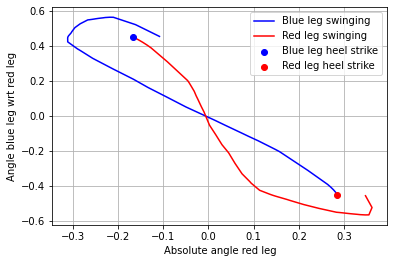

In [ ]:
# plot swing trajectories
# the second is the mirrored one
plt.plot(q_opt[:, 2], q_opt[:, 3], color='b', label='Blue leg swinging')
plt.plot(q_opt[:, 2] + q_opt[:, 3], - q_opt[:, 3], color='r', label='Red leg swinging')

# scatter heel strikes
plt.scatter(q_opt[0, 2] + q_opt[0, 3], - q_opt[0, 3], color='b', zorder=3, label='Blue leg heel strike')
plt.scatter(q_opt[0, 2], q_opt[0, 3], color='r', zorder=3, label='Red leg heel strike')

# misc options
plt.xlabel('Absolute angle red leg')
plt.ylabel('Angle blue leg wrt red leg')
plt.grid(True)
plt.legend()

Here we plot the absolute angle of the red leg versus its time derivative.
Again we complete the cycle by mirroring the result of the trajectory step.

If you did thing correctly, this figure should resemble [Figure 4.10 from the lecture notes](http://underactuated.mit.edu/simple_legs.html#compass_gait) (with reversed signs).
Note that the angle of the red leg is continuous during the walking cycle, while its time derivative has two jumps.

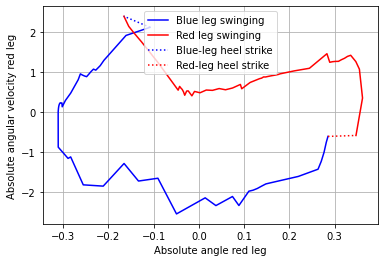

In [ ]:
# plot swing trajectories
# the second is the mirrored one
plt.plot(q_opt[:, 2], qd_opt[:, 2], color='b', label='Blue leg swinging')
plt.plot(q_opt[:, 2] + q_opt[:, 3], qd_opt[:, 2] + qd_opt[:, 3], color='r', label='Red leg swinging')

# plot heel strikes
plt.plot(
    [q_opt[-1, 2], q_opt[0, 2] + q_opt[0, 3]],
    [qd_opt[-1, 2], qd_opt[0, 2] + qd_opt[0, 3]],
    linestyle=':',
    color='b',
    label='Blue-leg heel strike'
)
plt.plot(
    [q_opt[0, 2], q_opt[-1, 2] + q_opt[-1, 3]],
    [qd_opt[0, 2], qd_opt[-1, 2] + qd_opt[-1, 3]],
    linestyle=':',
    color='r',
    label='Red-leg heel strike'
)

# misc options
plt.xlabel('Absolute angle red leg')
plt.ylabel('Absolute angular velocity red leg')
plt.grid(True)
plt.legend()

[0.54309868 0.54809868 0.55309868 0.55809868 0.56309868 0.58135722
 0.60635722 0.61135722 0.61635722 0.62135722 0.62635722 0.63135722
 0.64081127 0.64766874 0.66409008 0.6752207  0.7002207  0.7252207
 0.7502207  0.7752207  0.8002207  0.8252207  0.8502207  0.8552207
 0.8802207  0.9052207  0.9102207  0.9152207  0.9202207  0.9252207
 0.9302207  0.9352207  0.9402207  0.9452207  0.9502207  0.9552207
 0.9802207  1.0052207  1.0302207  1.0352207  1.0402207  1.0452207
 1.0502207  1.0552207  1.0602207  1.0652207  1.0702207  1.07866447
 1.08502768 1.11002768]
[[ 9.42328621e-01 -1.21438493e-01  2.85390344e-01 -4.50977903e-01
   0.00000000e+00  0.00000000e+00]
 [ 9.52887995e-01 -1.19649046e-01  2.81647189e-01 -4.36528217e-01
   2.07174461e-02 -2.30131337e-13]
 [ 9.62766595e-01 -1.18063323e-01  2.76646786e-01 -4.21527642e-01
   4.21704356e-02  4.34237238e-14]
 [ 9.72032913e-01 -1.16655956e-01  2.70533875e-01 -4.06048399e-01
   6.39719209e-02  1.25119964e-13]
 [ 9.80735910e-01 -1.15407004e-01  2.6343

<Figure size 18432x36864 with 0 Axes>

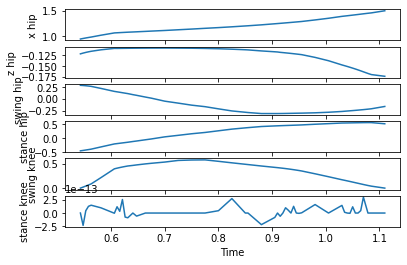

In [ ]:
plt.figure(figsize=(256,512))
fig, ax = plt.subplots(6)
labels = ['x hip', 'z hip', 'swing hip', 'stance hip', 'swing knee', 'stance knee']
for i in range(6):
  ax[i].plot(time_breaks_opt[-T:], q_opt[:-1,i], label=labels[i])
  ax[i].set_xlabel('Time')
  ax[i].set_ylabel(labels[i])

print(time_breaks_opt[-T:])
print(q_opt)

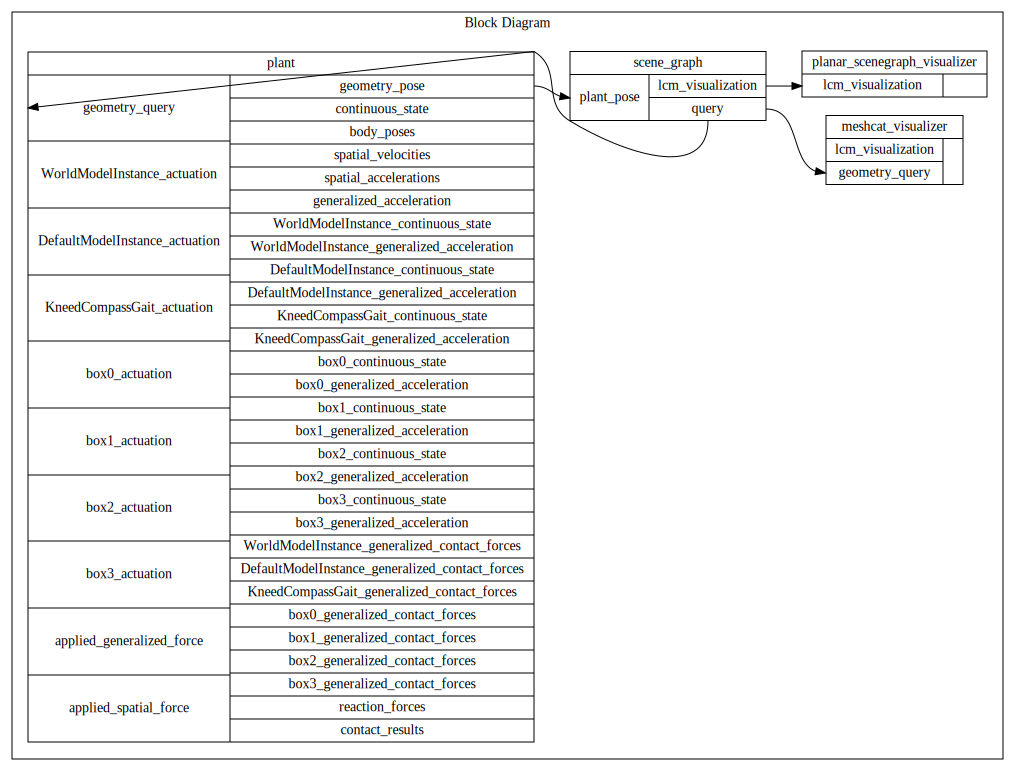

In [ ]:
diagram.set_name("Block Diagram")
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg())